In [55]:
import pandas as pd
import psycopg2
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import re

url = "https://caioicy.github.io/slsa/leaderboards/"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36"}
req = Request(url, headers=headers)
response = urlopen(req)
html = response.read()
soup = BeautifulSoup(html, 'html.parser')

tabela = soup.find('table')
df = pd.read_html(str(tabela), flavor='html5lib')[0]

df['RANK'] = df['RANK'].str.replace('NEW!', '')
df['RANK'] = df['RANK'].str.extract(r'(\d+)')
rating_parts = df['RATING'].str.extract(r'(\d+)\s+(\w+\s*\w*)')
df['RATING_NUMBER'] = rating_parts[0]
df['RATING_ELO'] = rating_parts[1]

df.drop(columns=['CHARACTERS'], inplace=True)

conexao = psycopg2.connect(database="melee",
                           host="localhost",
                           user="postgres",
                           password="postgres",
                           port="5432")

cursor = conexao.cursor()
cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = 'melee')")
table_exists = cursor.fetchone()[0]

if table_exists:
    for index, row in df.iterrows():
        cursor.execute("DROP TABLE melee")
        cursor.execute('''
        CREATE TABLE melee (
            ID SERIAL PRIMARY KEY,
            RANK INT,
            PLAYER VARCHAR(255),
            RATING_NUMBER INT,
            RATING_ELO VARCHAR(255),
            SETS VARCHAR(255)
        )
    ''')

    for index, row in df.iterrows():
            cursor.execute("INSERT INTO melee (RANK, PLAYER, RATING_NUMBER, RATING_ELO, SETS) VALUES (%s, %s, %s, %s, %s)",
                       (row['RANK'], row['PLAYER'], row['RATING_NUMBER'], row['RATING_ELO'], row['SETS']))
else:
    cursor.execute('''
        CREATE TABLE melee (
            ID SERIAL PRIMARY KEY,
            RANK INT,
            PLAYER VARCHAR(255),
            RATING_NUMBER INT,
            RATING_ELO VARCHAR(255),
            SETS VARCHAR(255)
        )
    ''')

    for index, row in df.iterrows():
            cursor.execute("INSERT INTO melee (RANK, PLAYER, RATING_NUMBER, RATING_ELO, SETS) VALUES (%s, %s, %s, %s, %s)",
                       (row['RANK'], row['PLAYER'], row['RATING_NUMBER'], row['RATING_ELO'], row['SETS']))

conexao.commit()
conexao.close()

#CRIANDO TABELA COM OS CÓDIGOS

html_string = str(html)

html_string_sem_colchetes = html_string.replace('[', '!')
html_string_treated = html_string_sem_colchetes.replace(']', '!')

country_codes = re.findall(r'countryCode\\\\":(.*?),', html_string_treated)
slippi_connect_codes = re.findall(r'slippiConnectCodes\\\\":!(.*?),', html_string_treated)
del country_codes[51] # foi identificado 1 jogador que possui país associado, mas não possui código. aqui, eu apago
country_codes = [code.replace('\\', '') for code in country_codes]
country_codes = [code.replace('"', '') for code in country_codes]
country_codes = [code.replace('}', '') for code in country_codes]
slippi_connect_codes = [code.replace('\\', '') for code in slippi_connect_codes]
slippi_connect_codes = [code.replace('!', '') for code in slippi_connect_codes]
slippi_connect_codes = [code.replace('}', '') for code in slippi_connect_codes]
slippi_connect_codes = [code.replace('"', '') for code in slippi_connect_codes]


# codigo para encontrar o texto que varia = (.*?)
# como estão os dados lá no html:
# \\\\"tr\\\\":{\\\\"slug\\\\":\\\\"tr\\\\",\\\\"tag\\\\":\\\\"TXR\\\\",
# \\\\"countryCode\\\\":\\\\"br\\\\",\\\\"slippiConnectCodes\\\\":c\\\\"TXR#205\\\\"u,\\\\"subregion\\\\":\\\\"br\\\\"}

countrysize = len(country_codes)
codesize = len(slippi_connect_codes)

csvcodes = pd.DataFrame({'codes': slippi_connect_codes})
csvpaises = pd.DataFrame({'paises': country_codes})
csvcodes.to_csv('codigos_brutos.csv', index=False)
csvpaises.to_csv('paises_brutos.csv', index=False)


df = pd.DataFrame({'CountryCode': country_codes, 'SlippiConnectCodes': slippi_connect_codes})

conexao = psycopg2.connect(database="melee",
                           host="localhost",
                           user="postgres",
                           password="postgres",
                           port="5432")

cursor = conexao.cursor()
cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = 'melee_paises')")
table_exists = cursor.fetchone()[0]

cursor.execute('''
ALTER TABLE melee ADD COLUMN PLAYER_NAME VARCHAR(255);

ALTER TABLE melee ADD COLUMN PLAYER_CODE VARCHAR(255);

UPDATE melee SET PLAYER_NAME = REGEXP_REPLACE(PLAYER, ' [A-Za-z#0-9]+$', '');

UPDATE melee SET PLAYER_CODE = REGEXP_REPLACE(PLAYER, '^.+ ', '');
''')
cursor.execute("ALTER TABLE melee DROP COLUMN player")
if table_exists:
    for index, row in df.iterrows():
        cursor.execute("DROP TABLE melee_paises")
        cursor.execute('''
        CREATE TABLE melee_paises (
            ID SERIAL PRIMARY KEY,
            COUNTRYCODE VARCHAR(255),
            SLIPPICONNECTCODES VARCHAR(255)
        )
    ''')
    for index, row in df.iterrows():
        cursor.execute("INSERT INTO melee_paises (COUNTRYCODE, SLIPPICONNECTCODES) VALUES (%s, %s)",
                       (row['CountryCode'], row['SlippiConnectCodes']))

        
else:
    cursor.execute('''
        CREATE TABLE melee_paises (
            ID SERIAL PRIMARY KEY,
            COUNTRYCODE VARCHAR(255),
            SLIPPICONNECTCODES VARCHAR(255)
        );
    ''')

    for index, row in df.iterrows():
        cursor.execute("INSERT INTO melee_paises (COUNTRYCODE, SLIPPICONNECTCODES) VALUES (%s, %s)",
                       (row['CountryCode'], row['SlippiConnectCodes']))

conexao.commit()
conexao.close()

import pandas as pd
import psycopg2
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import re

url = "https://caioicy.github.io/slsa/leaderboards/"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36"}
req = Request(url, headers=headers)
response = urlopen(req)
html = response.read()
soup = BeautifulSoup(html, 'html.parser')

html_string = str(html)

html_string_sem_colchetes = html_string.replace('[', '!')
html_string_treated = html_string_sem_colchetes.replace(']', '!')

country_codes = re.findall(r'countryCode\\\\":(.*?),', html_string_treated)
slippi_connect_codes = re.findall(r'slippiConnectCodes\\\\":!(.*?),', html_string_treated)
del country_codes[51] # foi identificado 1 jogador que possui país associado, mas não possui código. aqui, eu apago
country_codes = [code.replace('\\', '') for code in country_codes]
country_codes = [code.replace('"', '') for code in country_codes]
country_codes = [code.replace('}', '') for code in country_codes]
slippi_connect_codes = [code.replace('\\', '') for code in slippi_connect_codes]
slippi_connect_codes = [code.replace('!', '') for code in slippi_connect_codes]
slippi_connect_codes = [code.replace('}', '') for code in slippi_connect_codes]
slippi_connect_codes = [code.replace('"', '') for code in slippi_connect_codes]


# codigo para encontrar o texto que varia = (.*?)
# como estão os dados lá no html:
# \\\\"tr\\\\":{\\\\"slug\\\\":\\\\"tr\\\\",\\\\"tag\\\\":\\\\"TXR\\\\",
# \\\\"countryCode\\\\":\\\\"br\\\\",\\\\"slippiConnectCodes\\\\":c\\\\"TXR#205\\\\"u,\\\\"subregion\\\\":\\\\"br\\\\"}

countrysize = len(country_codes)
codesize = len(slippi_connect_codes)


df = pd.DataFrame({'CountryCode': country_codes, 'SlippiConnectCodes': slippi_connect_codes})
df.to_csv('paises_codes.csv', index=False)

conexao = psycopg2.connect(database="melee",
                           host="localhost",
                           user="postgres",
                           password="postgres",
                           port="5432")

cursor = conexao.cursor()
cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = 'melee_paises')")
table_exists = cursor.fetchone()[0]

if table_exists:
    for index, row in df.iterrows():
        cursor.execute("DROP TABLE melee_paises")
        cursor.execute('''
        CREATE TABLE melee_paises (
            ID SERIAL PRIMARY KEY,
            COUNTRYCODE VARCHAR(255),
            SLIPPICONNECTCODES VARCHAR(255)
        )
    ''')
    for index, row in df.iterrows():
        cursor.execute("INSERT INTO melee_paises (COUNTRYCODE, SLIPPICONNECTCODES) VALUES (%s, %s)",
                       (row['CountryCode'], row['SlippiConnectCodes']))

        
else:
    cursor.execute('''
        CREATE TABLE melee_paises (
            ID SERIAL PRIMARY KEY,
            COUNTRYCODE VARCHAR(255),
            SLIPPICONNECTCODES VARCHAR(255)
        );
    ''')

    for index, row in df.iterrows():
        cursor.execute("INSERT INTO melee_paises (COUNTRYCODE, SLIPPICONNECTCODES) VALUES (%s, %s)",
                       (row['CountryCode'], row['SlippiConnectCodes']))

cursor.execute("DROP TABLE IF EXISTS paises_players")
cursor.execute('''
CREATE TABLE paises_players AS
SELECT slippiconnectcodes, player_name, rating_number, countrycode, rating_elo from melee
INNER JOIN melee_paises
ON player_code = slippiconnectcodes
''')
cursor.execute("DROP TABLE IF EXISTS dados_pais")
cursor.execute('''
CREATE TABLE dados_pais AS
SELECT countrycode, AVG(rating_number) as avg_rating , COUNT(countrycode) as players FROM paises_players
GROUP BY countrycode
ORDER BY players DESC
               ''')
cursor.execute('''
UPDATE dados_pais
SET countrycode = 'USA'
WHERE countrycode = 'us';
UPDATE dados_pais
SET countrycode = 'CHL'
WHERE countrycode = 'cl';
UPDATE dados_pais
SET countrycode = 'VEN'
WHERE countrycode = 've';
UPDATE dados_pais
SET countrycode = 'URY'
WHERE countrycode = 'uy';
UPDATE dados_pais
SET countrycode = 'PER'
WHERE countrycode = 'pe';
UPDATE dados_pais
SET countrycode = 'COL'
WHERE countrycode = 'co';
UPDATE dados_pais
SET countrycode = 'ECU'
WHERE countrycode = 'ec';
UPDATE dados_pais
SET countrycode = 'BRA'
WHERE countrycode = 'br';
UPDATE dados_pais
SET countrycode = 'BOL'
WHERE countrycode = 'bo';
UPDATE dados_pais
SET countrycode = 'ARG'
WHERE countrycode = 'ar';
UPDATE dados_pais
SET countrycode = NULL
WHERE countrycode = 'null';
               ''')
query_dados = "SELECT * from dados_pais"

dados_paises = pd.read_sql_query(query_dados, conexao)

conexao.commit()
conexao.close()

C:\Users\junio\AppData\Local\Temp\ipykernel_27488\1386959945.py:288: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dados_paises = pd.read_sql_query(query_dados, conexao)


C:\Users\junio\AppData\Local\Temp\ipykernel_27488\3548607416.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dados_paises = pd.read_sql_query(query_dados, conexao)
C:\Users\junio\AppData\Local\Temp\ipykernel_27488\3548607416.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


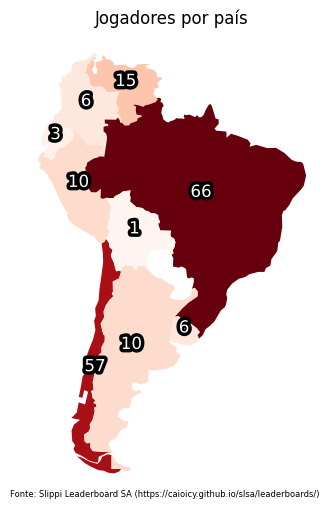

<Figure size 640x480 with 0 Axes>

In [98]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import psycopg2
from matplotlib import patheffects

conexao = psycopg2.connect(database="melee",
                           host="localhost",
                           user="postgres",
                           password="postgres",
                           port="5432")

cursor = conexao.cursor()

query_dados = "SELECT * from dados_pais"

dados_paises = pd.read_sql_query(query_dados, conexao)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

merged_df = pd.merge(dados_paises, world, left_on='countrycode', right_on='iso_a3', how='left')

geomapa = gpd.GeoDataFrame(merged_df, geometry='geometry')

cmap = 'Reds'
x_min, x_max = -90, -30  
y_min, y_max = -60, 10  
geomapa_americadosul = geomapa.cx[x_min:x_max, y_min:y_max]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
geomapa_americadosul.plot(column='players', cmap=cmap, legend=False, ax=ax)

# Adicionar rótulos
for index, row in geomapa_americadosul.iterrows():
    text = row['players']
    x, y = row['geometry'].centroid.coords[0]
    text_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    ax.annotate(text=text, xy=(x, y), fontsize=12, ha='center', color='white', path_effects=text_effect)

ax.set_axis_off()
ax.set_title('Jogadores por país')
ax.text(1, -0.01, 'Fonte: Slippi Leaderboard SA (https://caioicy.github.io/slsa/leaderboards/)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=6)
plt.show()
plt.savefig('mapa_jogadores.jpg')

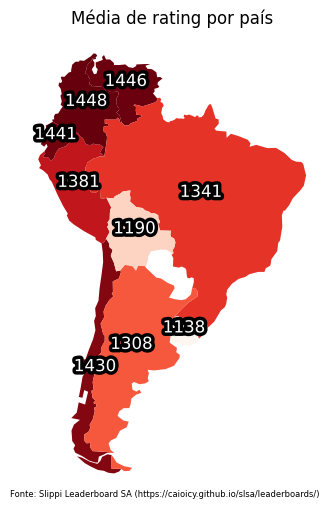

<Figure size 640x480 with 0 Axes>

In [99]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import patheffects

# Seu código para criar o geomapa...

# Criar a figura e o eixo
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
geomapa_americadosul.plot(column='avg_rating', cmap=cmap, legend=False, ax=ax)

for index, row in geomapa_americadosul.iterrows():
    avg_rating = round(row['avg_rating'])  # Arredonda o valor da média de rating
    text = f"{avg_rating}"
    x, y = row['geometry'].centroid.coords[0]
    text_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    ax.annotate(text=text, xy=(x, y), fontsize=12, ha='center', color='white', path_effects=text_effect)

ax.set_title('Média de rating por país')

ax.set_axis_off()
ax.text(1, -0.01, 'Fonte: Slippi Leaderboard SA (https://caioicy.github.io/slsa/leaderboards/)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=6)
plt.show()

plt.savefig('mapa_avg_rating.jpg')